Standard imports. Set the figsize on all plots to be 10 by 10

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from scipy.stats import expon,chi2,norm,gamma
matplotlib.rcParams['figure.figsize']=(10,10)

In [20]:
def save_fig( fig , fname="" , dir_path = "img" ):
    fig.savefig( dir_path + "/" + fname + '.png' , format='png' , dpi=100 )

# Load the data
***
For of the data files in the data directory, if it is a text file, add it to our dataset. Then concatenate the dataframes together

In [21]:
data_path = "data/"
data_frames = []
print("Files loaded:")
for filename in os.listdir(data_path):
    if filename.endswith(".txt"):
        print("\t"+filename)
        data_frames.append( pd.read_csv(data_path + filename) )
    
data = pd.concat(data_frames)
N = data.shape[0]
data.describe()

Files loaded:
	spring_break_data.txt
	first_dataset.txt
	data2.txt


,# time_interval (ns)
count,335508.000000
mean,2180.955924
std,3019.639121
min,0.000000
25%,240.000000
50%,1040.000000
75%,3120.000000
max,20400.000000


## Plot the Distribution of the Data and the Accepted value for Lifetime
***

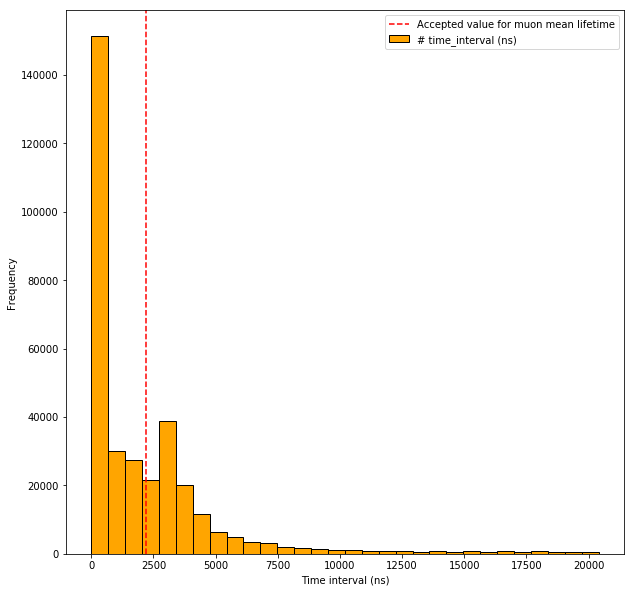

In [22]:
fig, ax = plt.subplots(1)
# plot a vertical line at accepted lifetime of 2.19 microseconds
ax.axvline(2.1969811e3,color='red',linestyle='dashed',label='Accepted value for muon mean lifetime')
data.plot(ax=ax,kind='hist',bins=30,color='orange',edgecolor='black')
ax.set_xlabel("Time interval (ns)")
plt.legend()
plt.show()

In [23]:
save_fig( fig , "data" )

# Frequentist
***

## Exponential Distribution
***
PDF:
$$f(x|\lambda)=\lambda e^{-\lambda x},\quad \lambda > 0$$

CDF:
$$g(x|\lambda)= 1 - e^{-\lambda x},\quad \lambda > 0$$

In this parametrization, $$\lambda = \frac{1}{\tau}$$

For this parametrization, you need to pass scale=$\frac{1}{\lambda}$ to scipy expon

MLE Lambda: 0.0004585145390605167/ns
MLE Estimate for Lifetime: 2180.955923554729ns


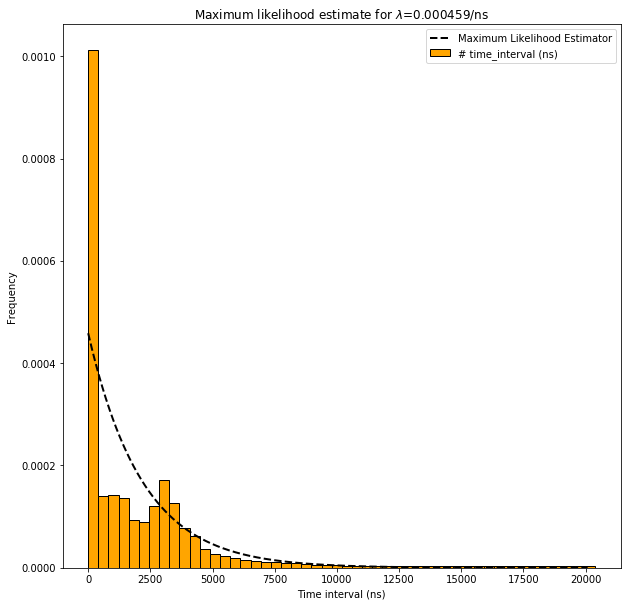

In [24]:
# MLE for lambda 
lambda_mle = 1./data.mean().values[0]

print("MLE Lambda: {}/ns".format(lambda_mle))
print("MLE Estimate for Lifetime: {}ns".format(1/lambda_mle))

fig2, ax = plt.subplots()

data.plot(ax=ax, kind='hist',density=1,bins=50,edgecolor='black',color='orange')

ts = np.linspace( expon.ppf( 1e-6, scale=1/lambda_mle ) , expon.ppf( 0.9999 ,scale=1./lambda_mle) , 1000 )
ax.plot( ts , expon.pdf( ts , scale=1/lambda_mle ), label="Maximum Likelihood Estimator" , 
         linestyle='dashed',linewidth=2,color='black')

ax.set_title("Maximum likelihood estimate for $\lambda$={:.6f}/ns".format(lambda_mle))
ax.set_xlabel("Time interval (ns)")
ax.legend()
save_fig( fig2, "mle_estimate" )
plt.show()

In [32]:
# 0.99 confidence interval
alpha = 0.01
lwr_bnd = chi2.ppf( alpha / 2 , df = 2 * N ) / ( 2. * np.sum(data) ).values[0]
upr_bnd = chi2.ppf( 1 - (alpha / 2) , df = 2 * N ) / ( 2. * np.sum(data) ).values[0]

print("Lower bound on confidence interval: {}".format(lwr_bnd))
print("Maximum likelihood estimate:        {}".format(lambda_mle))
print("Upper bound on confidence interval: {}".format(upr_bnd))

Lower bound on confidence interval: 0.00045647809889671494
Maximum likelihood estimate:        0.0004585145390605167
Upper bound on confidence interval: 0.0004605561130933471


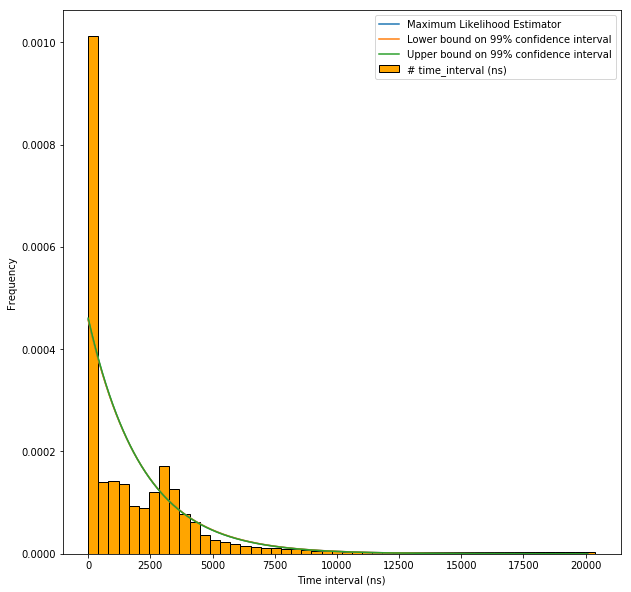

In [49]:
fig3, ax = plt.subplots()

data.plot(ax=ax,kind='hist',density=1,bins=50,edgecolor='black',color='orange')

ax.plot( ts , expon.pdf( ts, scale=1/lambda_mle ), label="Maximum Likelihood Estimator" )
ax.plot( ts , expon.pdf( ts, scale=1/lwr_bnd ), label="Lower bound on 99% confidence interval" )
ax.plot( ts , expon.pdf( ts, scale=1/upr_bnd ), label="Upper bound on 99% confidence interval" )
ax.set_xlabel("Time interval (ns)")
ax.legend()

save_fig( fig3 , "confidence_interval_with_data" )
plt.show()

Can't see the difference between the confidence interval bounds, so I wanted to look at just them by themselves:

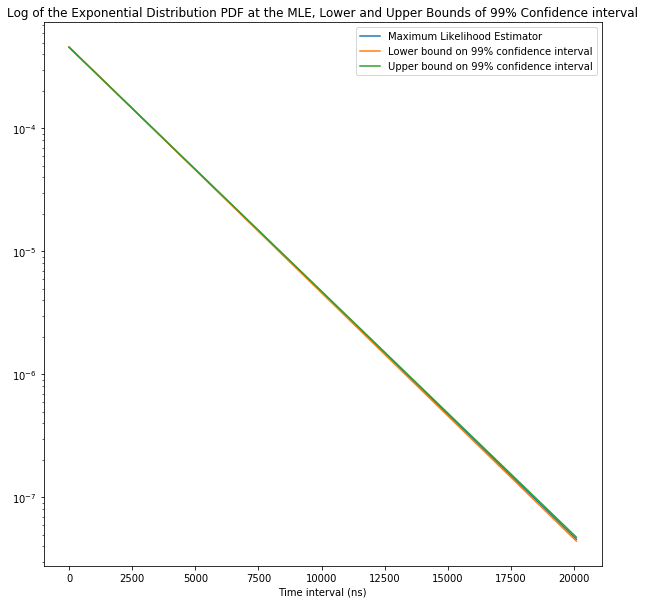

In [50]:
fig4, ax = plt.subplots()

ax.plot( ts , expon.pdf( ts, scale=1/lambda_mle ), label="Maximum Likelihood Estimator" )
# the lower bound on estimate for lambda is the upper bound for the estimate of 1/lambda=mean=beta=tau
ax.plot( ts , expon.pdf( ts, scale=1/upr_bnd ), label="Lower bound on 99% confidence interval" )
ax.plot( ts , expon.pdf( ts, scale=1/lwr_bnd ), label="Upper bound on 99% confidence interval" )
ax.set_yscale('log')
ax.legend()
ax.set_title("Log of the Exponential Distribution PDF at the MLE, Lower and Upper Bounds of 99% Confidence interval")
ax.set_xlabel("Time interval (ns)")
save_fig( fig4 , "log_distributions_confidence_interval" )
plt.show()

TODO:
Do resampling techniques to get an estimate for the upper, lower and mle values on the parameter, and plot their distributions

## Bayesian 
***
Use a Gamma prior, with $\alpha=1$ (so it reduces to an exponential distribution) and $\beta=c$ for some constant $c$. Plot the posterior for $\lambda$

In [35]:
def map_estimator(X, mu, sigma):
    pos = (mu/sigma**2)-X.sum() + np.sqrt((X.sum()-(mu/sigma))**2+4*X.shape[0])
    neg = (mu/sigma**2)-X.sum() - np.sqrt((X.sum()-(mu/sigma))**2+4*X.shape[0])
    return(pos/2., neg/2.)

MAP Estimator for lambda: 0.0004585385322570801


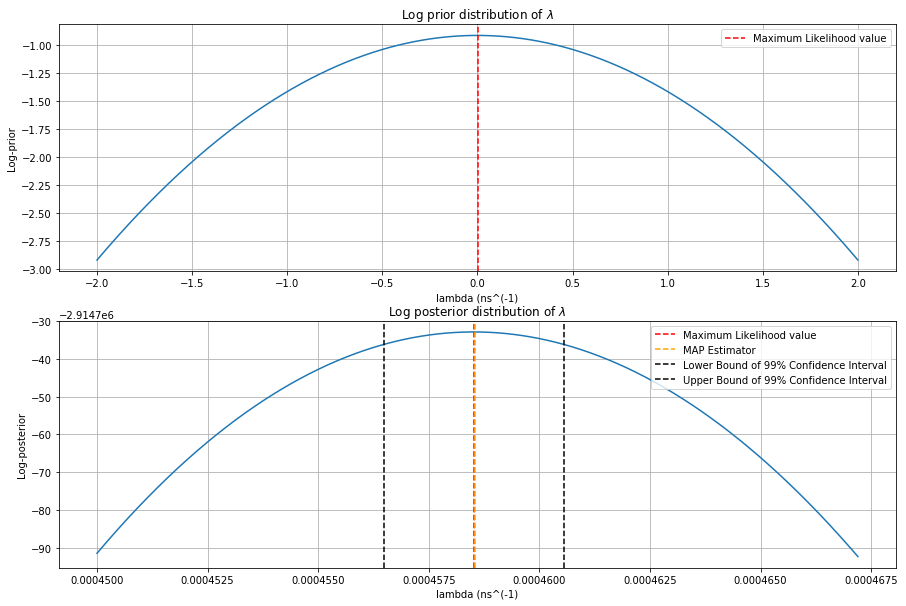

In [54]:
def log_likelihood(data, lambd):
    """
    Log likelihood under exponential distribution
    """
    return(N * np.log(lambd) - lambd * data.values.sum())


def log_norm_prior(lambd, mu=0, sigma=1):
    """
    Log of the normal distribution function
    """
    return -(1./2.) * (((lambd - mu) / sigma)**2 + np.log(2 * np.pi))


def log_posterior(lambd, x, mu=0, sigma=1):
    """
    Return the posterior
    """
    return(log_likelihood(x, lambd) + log_norm_prior(lambd, mu=mu, sigma=sigma))


print("MAP Estimator for lambda: {}".format(
    map_estimator(data.values, 0, 1)[0]))

lambdas = np.linspace(0.00045, 0.0004672, 1000)

prior_lambdas = np.linspace(-2, 2, 1000)

fig5, ax = plt.subplots(2, 1, figsize=(15, 10))

ax[1].plot(lambdas, log_likelihood(data, lambdas) +
           log_norm_prior(lambdas, 0, 1))
ax[1].axvline(lambda_mle, color='red', linestyle='dashed',
              label='Maximum Likelihood value')
ax[1].axvline(map_estimator(data.values, 0, 1)[0], color='orange', linestyle='dashed',
              label='MAP Estimator')
ax[1].axvline(lwr_bnd, color='black', linestyle='dashed',
              label='Lower Bound of 99% Confidence Interval')
ax[1].axvline(upr_bnd, color='black', linestyle='dashed',
              label='Upper Bound of 99% Confidence Interval')

ax[1].set_xlabel("lambda (ns^(-1)")
ax[1].set_ylabel("Log-posterior")
ax[1].set_title(r"Log posterior distribution of $\lambda$")
ax[1].legend(loc='upper right')
ax[1].grid()

ax[0].plot(prior_lambdas, log_norm_prior(prior_lambdas, 0, 1))
ax[0].axvline(lambda_mle, color='red', linestyle='dashed',
              label='Maximum Likelihood value')
ax[0].set_xlabel("lambda (ns^(-1)")
ax[0].set_ylabel("Log-prior")
ax[0].set_title(r"Log prior distribution of $\lambda$")
ax[0].legend()
ax[0].grid()

save_fig(fig5, "prior_versus_posterior")
plt.show()

We see that the positive root of our MAP estimate solution agrees with MLE to more than 6 decimal places

# Double Exp Fit
***


Variance: 
 [-2.33078006e+23  8.21746747e+13 -2.33078023e+23  8.20048128e+14
  2.80708309e+06]
Mean of counts: # time_interval (ns)     2180.955924
dtype: float64
Fitted value for muon lifetime: 1996.6725032345312 (ns)
[263929.19296322   1996.67250323  83691.31409415   1996.52962099
    964.85986035]


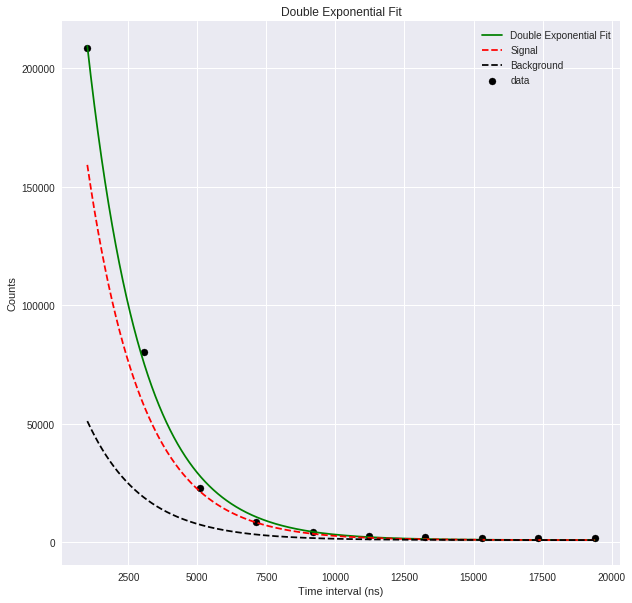

In [59]:
from scipy.optimize import curve_fit
def single_exp(t, N0, tau, b):
    return N0 * np.exp(- t / tau) + b

def f(t, N1, tau1, N2, tau2, C):
    return N1 * np.exp(- t / tau1) + N2 * np.exp(- t / tau2) + C

nbins = 10
N = 10000
counts, bin_edges = np.histogram(data, bins=nbins)
p0 = [counts[0] , np.mean(data) , counts[0]/2, 1.5 * np.mean(data) , 1 ]
xdata = (bin_edges[:-1] + bin_edges[1:]) / 2.
x = np.linspace(xdata.min(), xdata.max(), N)
popt, pcov = curve_fit(f, xdata, counts, p0=p0)
print("Variance: \n" ,np.diag(pcov))
plt.style.use('seaborn')
print("Mean of counts: {}".format( p0[1] ))
print("Fitted value for muon lifetime: {} (ns)".format( popt[1] ))

# NOTE: the fitting converges and works well, but realize that the variance
# on the parameters is enormous. hopefully more data will fix this issue.
# can't even plot 1 sigma bounds for the fit
fig6,ax = plt.subplots(1, figsize=(10,10))
ax.scatter(x=xdata, y=counts, label='data', color='black')
ax.plot(x, f(x, *popt), label='Double Exponential Fit', color='green')
ax.plot(x, single_exp(x, *popt[:2],popt[-1]), label='Signal',\
        linestyle='dashed',color='red')
ax.plot(x, single_exp(x, *popt[2:]), label='Background', \
        linestyle='dashed',color='black')
ax.set_xlabel(r"Time interval (ns)")
ax.set_ylabel("Counts")
ax.legend()
ax.set_title("Double Exponential Fit")
save_fig(fig6,"double_exp_fit")
print(popt)
plt.show()